In [1]:
from DiffeoOT import *
from utils import *
import torch
import time 
import os
os.environ['KMP_DUPLICATE_LIB_OK']='TRUE'

In [2]:
m=32

x = torch.linspace(-1,1,m)
y = torch.linspace(-1,1,m)
grid = torch.zeros((1,m,m,2)).to(dtype=torchdtype, device=torchdeviceId)
for i in range(0,m):
        for j in range(0,m):
            grid[0,i,j,0]= x[i]
            grid[0,i,j,1]= y[j]

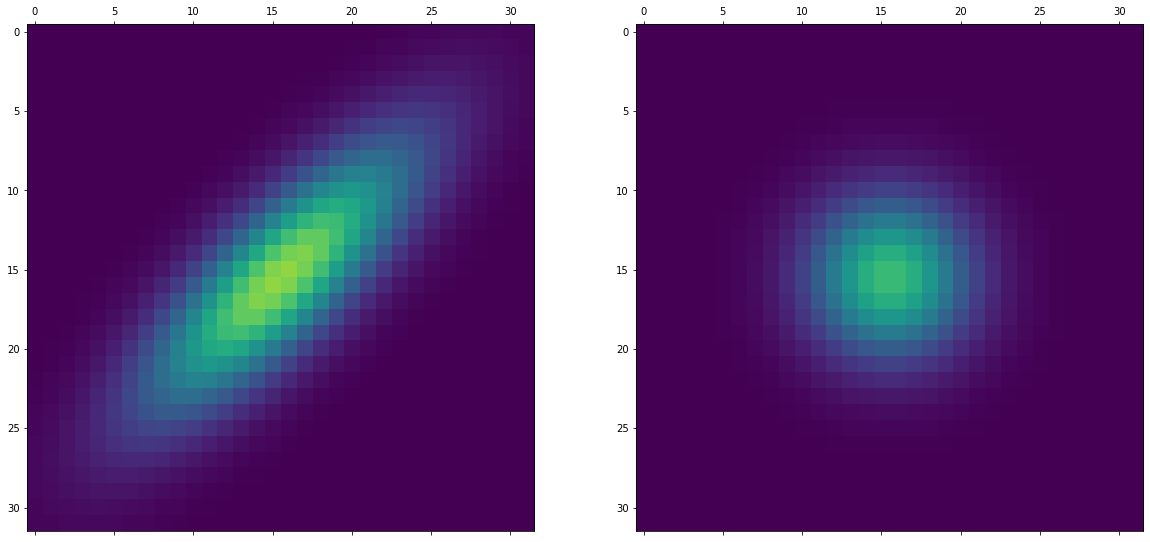

In [3]:
G1=torch.Tensor([[10,0],[0,10]]).to(dtype=torchdtype, device=torchdeviceId)
G2=torch.Tensor([[10,16],[0,10]]).to(dtype=torchdtype, device=torchdeviceId)
G3=torch.Tensor([[10,-16],[0,10]]).to(dtype=torchdtype, device=torchdeviceId)
mu_2 = (1/2)*gaussian(0,0,G1,grid)

mu_1 = normalize(gaussian(0,0,G2,grid))

plot_pair(mu_1,mu_2)

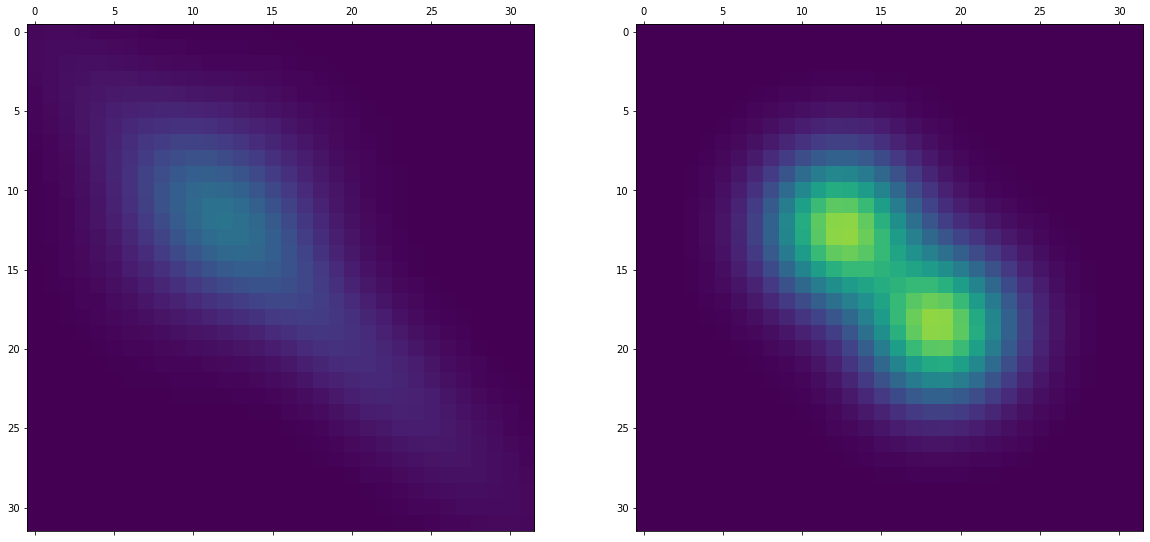

In [5]:
G1=torch.Tensor([[12,0],[0,12]]).to(dtype=torchdtype, device=torchdeviceId)
G2=torch.Tensor([[10,-18],[0,10]]).to(dtype=torchdtype, device=torchdeviceId)
G3=torch.Tensor([[7,0],[0,7]]).to(dtype=torchdtype, device=torchdeviceId)
mu_2 = 2*normalize(gaussian(.2,.2,G1,grid)+ gaussian(-.2,-.2,G1,grid))

mu_1 = normalize(gaussian(0,0,G2,grid)+gaussian(-.25,-.25,G3,grid))

plot_pair(mu_1,mu_2)

C:\Users\emanh\AppData\Roaming\Python\Python39\site-packages\torch\nn\functional.py:4227: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


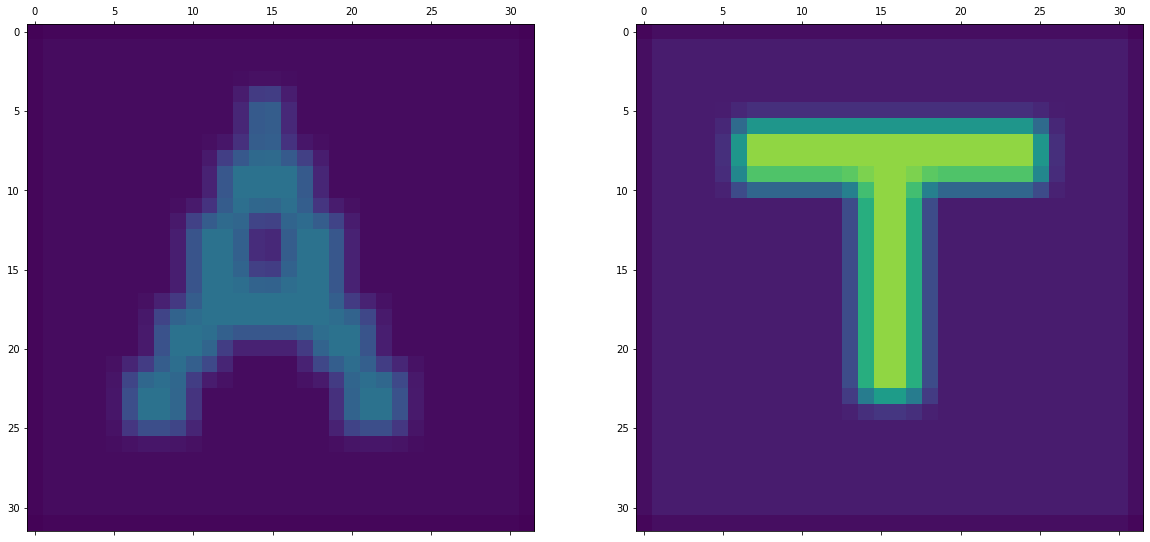

In [6]:
mu_2 = load_dist("T.png",grid)*2
G1=torch.Tensor([[2,0],[0,2]]).to(dtype=torchdtype, device=torchdeviceId)
mu_1 = load_dist("A.png",grid)
plot_pair(mu_1,mu_2)

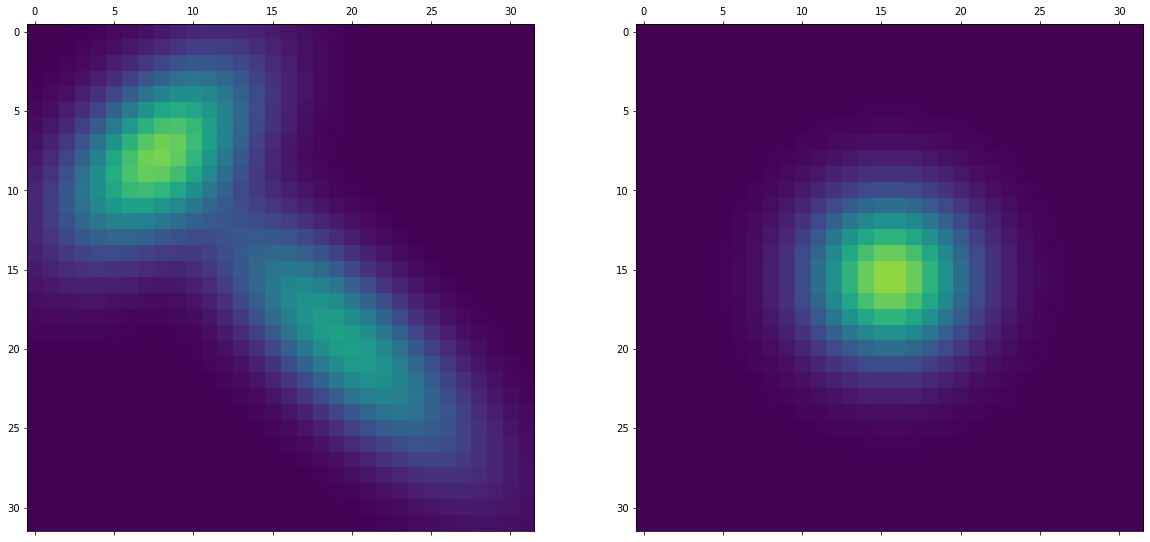

In [15]:
G1=torch.Tensor([[10,0],[0,10]]).to(dtype=torchdtype, device=torchdeviceId)
G2=torch.Tensor([[10,10],[0,10]]).to(dtype=torchdtype, device=torchdeviceId)
G3=torch.Tensor([[10,-15],[0,10]]).to(dtype=torchdtype, device=torchdeviceId)
mu_2 = gaussian(0,0,G1,grid)

mu_1 = 2*normalize(gaussian(-.5,-.5,G2,grid)+gaussian(.25,.25,G3,grid))

plot_pair(mu_1,mu_2)

In [16]:
params=[]
params+=[{'T':12, 'match_coeff':1000000000, 'path_coeff':1}]
delta=1

In [17]:
def L(out):
    #out=torch.unsqueeze(out,0)
    #weight = torch.Tensor([[[[0,1,0],[1,-4,1],[0,1,0]]]]).to(dtype=torchdtype, device=torchdeviceId)/4
    #out = tnn.conv2d(out,weight.repeat(2,1,1,1), padding='same',groups=2)
    #out = tnn.conv2d(out,weight.repeat(2,1,1,1), padding='same',groups=2)
    #out = tnn.conv2d(out,weight.repeat(2,1,1,1), padding='same',groups=2)
    #out = tnn.conv2d(out,weight.repeat(2,1,1,1), padding='same',groups=2)
    #out = tnn.conv2d(out,weight.repeat(2,1,1,1), padding='same',groups=2)
    return out

In [18]:
def inner_prod(X,source,p,grid):
    pm=p
    pX= pm*X.transpose(0,2)
    return ((L(pX)**2).sum(dim=0)/(pm)*(4/(m**2))).sum() 

In [19]:
start =time.time()
vecs,funs,ps = DiffeoOUT_multires(mu_1,mu_2,grid,params,inner_prod,delta)
print(time.time()-start)
pl_pathlength = path_length(grid,mu_1,inner_prod,vecs,funs,delta)
print(pl_pathlength)
N=vecs.shape[0]

2.640289068222046
[1.651653   1.72734931 1.87545686 2.11280544 1.0000037  0.9334787
 0.96551794 1.02781667 1.14148235 1.33555205 1.76979819]


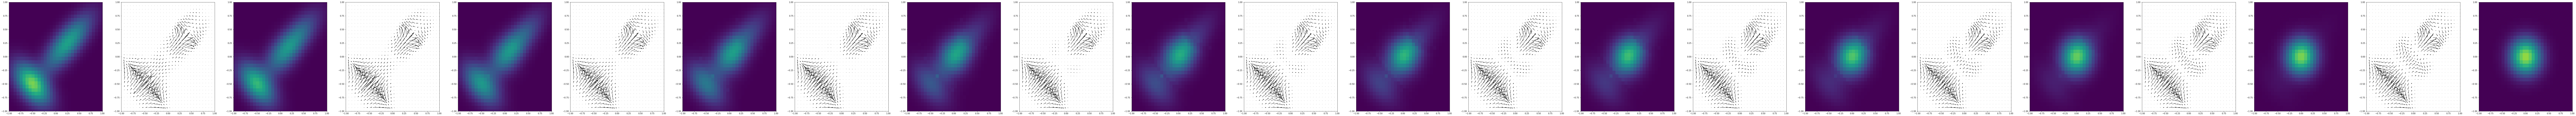

(120, 32, 32)


In [20]:
plot_sequence(mu_1,mu_2,grid,ps,vecs,funs)
save_gif(mu_1,mu_2,ps)

In [21]:
print(pl_pathlength.sum()/pl_pathlength.shape[0])

1.412810382461968


In [22]:
def kl(p, q):
    logpq = np.log((p + 1e-100) / (q + 1e-100))
    kl = (p * logpq + q - p).sum()

    return kl

def klobjective(plan, M, a,b, reg_m=1):
    f=(plan*M).sum()
    f+=kl(plan.sum(axis=1),a)
    f+=kl(plan.sum(axis=0),b)
    return f  

In [23]:
import ot
reg=.00075
a=mu_1.reshape(m*m).cpu().numpy()
b=mu_2.reshape(m*m).cpu().numpy()
supports = grid.reshape(m*m,1,2)
M=((supports-supports.transpose(0,1))**2).sum(dim=2).cpu().numpy()/(delta)
M[M>=np.pi]=np.pi/2
M=np.cos(M)
M[M<=0]=1e-100
M=-1*np.log(M)
plan,log=ot.unbalanced.sinkhorn_unbalanced(a, b, M, reg, 1,numItermax=2000, stopThr=1e-6,log=True)

Wd=2*delta*np.sqrt(klobjective(plan,M,a,b))
print(Wd)

0.9325979267277185


C:\Users\emanh\AppData\Roaming\Python\Python39\site-packages\ot\unbalanced.py:398: RuntimeWarning: overflow encountered in true_divide
  u = (a / Kv) ** fi
C:\Users\emanh\AppData\Roaming\Python\Python39\site-packages\ot\unbalanced.py:407: UserWarning: Numerical errors at iteration 891
  warnings.warn('Numerical errors at iteration %s' % i)
